# 0. Preliminaries
**All codes in Section 0 need to be run before any models can be built.**

## 0.1 Constants Declaration
**Constants that represent absolute paths should be changed to match the folder and file locations of the inputs.**

In [2]:
TRAINING_DIR = r"D:\ARCHIVED\University Files\VI\aml\a2\classification\train"
TESTING_DIR = r"D:\ARCHIVED\University Files\VI\aml\a2\classification\test"
TESTING_PAIRS_TXT = r"D:\ARCHIVED\University Files\VI\aml\a2\verification_pairs_val.txt"
TESTING_PAIRS_DIR = r"D:\ARCHIVED\University Files\VI\aml\a2"
IMAGE_SIZE = (64,64)
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.1
#DIR_PATH = r"D:\ARCHIVED\University Files\VI\aml\a2\verification_data"
#TXT_PATH = r"D:\ARCHIVED\University Files\VI\aml\a2\verification_pairs_val.txt"
#TRAINING_PAIRS = 4096
#TESTING_PAIRS = 128

## 0.2 Simple ML Builder Class
This class is created entirely by hand, to simplify the process of building and training the model.

In [3]:
import sys, math

def smlb_log(*message, sep:str=" "):
	print("[SMLB]", *message, sep=sep)

def smlb_log_error(*message, sep:str=" "):
	print("[SMLB]", *message, sep=sep, file=sys.stderr)

smlb_log("Loading compulsory modules...")

smlb_log("Loading TensorFlow... this will take a while.")
import tensorflow as TensorFlow
Keras = TensorFlow.keras
smlb_log("TensorFlow loaded! TensorFlow version is", TensorFlow.__version__ + ".")

smlb_log("Loading NumPy...")
import numpy as NumPy
smlb_log("NumPy loaded!")

smlb_log("Loading PyPlot...")
from matplotlib import pyplot as PyPlot
smlb_log("PyPlot loaded!")

smlb_log("All compulsory imports successful!")
smlb_log("Loading optional modules...")

smlb_log("Loading TensorFlow Addons...")
try:
	import tensorflow_addons as TensorFlowAddons
except ImportError:
	smlb_log("TensorFlow Addons not installed.")
else:
	smlb_log("TensorFlow Addons loaded! TensorFlow Addons version is", TensorFlowAddons.__version__ + ".")

smlb_log("Loading SciKitLearn...")
try:
	import sklearn
except ImportError:
	smlb_log("SciKitLearn not installed.")
else:
	smlb_log("SciKitLearn loaded!")
	
smlb_log("Optional module imports processed.")

class SimpleMLBuilder:
	def __init__(self, verbose:bool=False):
		self.datasets = {"training": [None, None], "validation": None, "testing": [None, None]}
		self.layers = []
		self.labels = []
		self.verbose = verbose
		self.history = None
		self.log("Fully initialized!")
	
	def log(self, *message, sep:str=" ", nonVerbose:bool=False):
		if self.verbose or nonVerbose:
			smlb_log(*message, sep=sep)
	
	def log_error(self, *message, sep:str=" ", nonVerbose:bool=False):
		if self.verbose or nonVerbose:
			smlb_log_error(*message, sep=sep)
	
	def load_preset_dataset(self, preset:str):
		"""Loads a preset dataset with Keras.
		
		Built-in presets: MNIST & Fashion MNIST.
		Useful for testing the SMLB.
		"""
		preset = preset.lower()
		if preset == "mnist":
			self.log("Loading preset \"MNIST\"...")
			
			(trainingXs, trainingYs), (testingXs, testingYs) = Keras.datasets.mnist.load_data()
			
			self.datasets["training"] = [trainingXs, trainingYs]
			self.log("Training set loaded from preset.")
			
			self.datasets["testing"] = [testingXs, testingYs]
			self.log("Testing set loaded from preset.")
			
			self.log("Preset \"MNIST\" loaded successfully.")
		elif preset == "fashion mnist":
			self.log("Loading preset \"Fashion MNIST\"...")
			
			(trainingXs, trainingYs), (testingXs, testingYs) = Keras.datasets.fashion_mnist.load_data()
			self.labels = [
				None,
				["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
				"Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
			]
			
			self.datasets["training"] = [trainingXs, trainingYs]
			self.log("Training set loaded from preset. Training images has shape of", str(trainingXs.shape) + ".")
			
			self.datasets["testing"] = [testingXs, testingYs]
			self.log("Testing set loaded from preset. Testing images has shape of", str(testingXs.shape) + ".")
			
			self.log("Preset \"Fashion MNIST\" loaded successfully.")
		else:
			self.log_error("Preset \"" + preset + "\" not found.")
	
	def set_training_features(self, features):
		"""Sets the features used for training.
		
		Features can be a list of entries or a dataset.
		"""
		
		self.datasets["training"][0] = features
		self.log("Training X values have been set!")
	def set_training_labels(self, labels=None):
		"""Sets the labels used for training.
		
		Labels should be a list of entries.
		If a TensorFlow.data.Dataset is used for the training features, the labels specified here are ignored.
		"""
		
		self.datasets["training"][1] = labels
		self.log("Training Y values have been set!")
	def set_testing_features(self, features):
		"""Sets the features used for testing.
		
		Features can be a list of entries or a dataset.
		"""
		
		self.datasets["testing"][0] = features
		self.log("Testing X values have been set!")
	def set_testing_labels(self, labels=None):
		"""Sets the labels used for testing.
		
		Labels should be a list of entries.
		If a TensorFlow.data.Dataset is used for the testing features, the labels specified here are ignored.
		"""
		
		self.datasets["testing"][1] = labels
		self.log("Testing Y values have been set!")
	def set_validation_dataset(self, dataset):
		"""Sets the dataset used for validation.
		
		Dataset should either be a TensorFlow.data.Dataset or a list of feature-label tuples.
		"""
		
		self.datasets["validation"] = dataset
		self.log("Validation dataset has been set!")
	
	def get_training_features(self):
		return self.datasets["training"][0]
	def get_training_labels(self):
		return self.datasets["training"][1]
	def get_testing_features(self):
		return self.datasets["testing"][0]
	def get_testing_labels(self):
		return self.datasets["testing"][1]
	
	def get_feature_classes(self):
		return self.labels[0]
	def get_label_classes(self, y:bool=False):
		return self.labels[1]
	
	def start_layering(self, inputShape:tuple=None):
		"""Starts the creation of a new model.
		
		This method also creates an input layer and adds it to the model.
		"""
		
		self.layers.clear()
		layer = {"type": "Input", "shape": inputShape}
		self.layers.append(layer)
		self.log("Layering started. Added layer:", layer)
	
	def _add_layer(self, layer:dict):
		self.layers.append(layer)
		self.log("Added layer:", layer)
	def add_dense_layer(self, neurons:int):
		"""Adds a densely-connected layer to the model.
		
		Dense layers are the bread and butter of any Deep Neural Network.
		"""
		layer = {"type": "Dense", "units": neurons}
		self._add_layer(layer)
	def add_activation_layer(self, activation:str=None):
		"""Adds an activation layer to the model.
		
		Possible activations: relu.
		If there is a dense or convolution layer before this layer, that layer will be modified instead.
		"""
		layer = self.layers.pop()
		layerType = layer["type"]
		if layerType == "Dense" or layerType == "Conv2D":
			layer["activation"] = activation
			self.layers.append(layer)
			self.log("Modified layer:", layer)
		else:
			self.layers.append(layer)
			self._add_layer({"type": activation})
	def add_rescaling_layer(self, scale:float=1.0/255, offset:float=0.0):
		"""Adds a rescaling layer to the model.
		
		Used to add and multiply values of the previous layer.
		Typically used as a preprocessing layer.
		"""
		layer = {"type": "Rescaling", "scale": scale, "offset": offset}
		self._add_layer(layer)
	def add_regularization_sublayer(self, regularization:str=None, regAmount:float=0.0):
		"""Modifies the previous layer to use regularization.
		
		Possible regularizations: l1, l2.
		"""
		layer = self.layers.pop()
		if regularization=="l1":
			layer["kernel_regularizer"] = Keras.regularizers.l1(regAmount)
		elif regularization=="l2":
			layer["kernel_regularizer"] = Keras.regularizers.l2(regAmount)
		self.layers.append(layer)
		self.log("Modified layer:", layer)
	def add_regularization_layer(self, regularization:str=None, regAmount:float=0.0):
		"""Adds a regularization layer to the model, as a lambda layer.
		
		If this layer is being attached to the previous layer, consider using add_regularization_sublayer instead.
		Possible regularizations: l2.
		"""
		if regularization=="l2":
			layer = {"type": "Lambda", "function": lambda x: TensorFlow.math.l2_normalize(x, axis=1)}
		self._add_layer(layer)
	def add_flatten_layer(self):
		"""Adds a flattening layer to the model.
		
		Flattening layers turn a n-dimensional input into a (n-1)-dimensional input,
		where each vector in the tensor is concatenated with the last.
		"""
		layer = {"type": "Flatten"}
		self._add_layer(layer)
	def add_softmax_layer(self):
		"""Adds a softmax layer to the model.
		
		Softmax layers turn a tensor of logistic values into a tensor of probablistic values.
		"""
		layer = {"type": "Softmax"}
		self._add_layer(layer)
	def add_dropout_layer(self, probability:float):
		"""Adds a dropout layer to the model.
		
		Dropout layers have a chance to output 0 instead of the previous layer's values.
		"""
		layer = {"type": "Dropout", "rate": probability}
		self._add_layer(layer)
	def add_normalization_layer(self, axis:int=None):
		"""Normalizes input to be within a normal distribution of mean 0 and standard variance 1."""
		layer = {"type": "Normalization", "axis": axis}
		self._add_layer(layer)
	def add_convolution_layer(self, filters:int, filterSize:tuple, stride:tuple=(1,1), pad:bool=False):
		"""Adds a convolution layer to the model.
		
		Convolution layers help to get certain image data features of the previous layer.
		"""
		layer = {"type": "Conv2D", "filters": filters, "kernel_size": filterSize, "strides": stride, "padding": "same" if pad else "valid"}
		self._add_layer(layer)
	def add_pooling_layer(self, method:str="max", filterSize:tuple=(1,1), stride:tuple=(1,1)):
		"""Adds a pooling layer to the model.
		
		Pooling layers help to summarize image data of the previous layer.
		"""
		if method=="max":
			layer = {"type": "MaxPool2D", "pool_size": filterSize, "strides": stride}
			self._add_layer(layer)
	
	def add_random_contrast_layer(self, minimum:float, maximum:float=None):
		"""Adds random image contrast to the input and outputs it.
		
		Input can be negative to reduce image contrast."""
		if not maximum:
			maximum = minimum
		else:
			minimum = -minimum
		
		layer = {"type": "RandomContrast", "factor": (minimum, maximum)}
		self._add_layer(layer)
	def add_random_flip_layer(self, x:bool=False, y:bool=False):
		"""Has a 50% chance to flip the input around a given axis.
		
		x = allow horizontal flip, y = allow vertical flip
		"""
		flip = y and [x and "horizontal_and_vertical" or "vertical"] or "horizontal"
		
		layer = {"type": "RandomFlip", "mode": flip}
		self._add_layer(layer)
	def add_random_rotation_layer(self, minimum:float, maximum:float=None):
		"""Randomly rotates the input around its center clockwise by the given amount of radians.
		
		Input can be negative to rotate counter-clockwise.
		"""
		if not maximum:
			maximum = minimum
			minimum = -minimum
		
		layer = {"type": "RandomRotation", "factor": (minimum, maximum)}
		self._add_layer(layer)
	def add_random_zoom_layer(self, minimum:float, maximum:float=None):
		"""Randomly zooms the input image by the given multiplier.
		
		Input can be negative to zoom out, up to > -1.
		"""
		if not maximum:
			maximum = minimum
			minimum = -minimum
		
		layer = {"type": "RandomZoom", "height_factor": (minimum, maximum)}
		self._add_layer(layer)
	
	def get_layers(self) -> list:
		return self.layers
	
	def set_scc_loss_function(self):
		"""Sets the loss function to TensorFlow.keras.losses.SparseCategoricalCrossentropy.
		
		Always softmaxes input.
		"""
		self.lossFunction = Keras.losses.SparseCategoricalCrossentropy(from_logits=True)
		self.log("Set loss function:", self.lossFunction)
	def set_bc_loss_function(self):
		"""Sets the loss function to TensorFlow.keras.losses.BinaryCrossentropy.
		
		Always softmaxes input.
		"""
		self.lossFunction = Keras.losses.BinaryCrossentropy(from_logits=True)
		self.log("Set loss function:", self.lossFunction)
	def set_mae_loss_function(self):
		"""Sets the loss function to the mean absolute error."""
		self.lossFunction = "mean_absolute_error"
		self.log("Set loss function:", self.lossFunction)
	def set_custom_loss_function(self, loss:Keras.losses):
		"""Sets the loss function to the passed value."""
		self.lossFunction = loss
		self.log("Set loss function:", self.lossFunction)
	
	def _create_layer(self, layerData:dict) -> Keras.layers.Layer:
		layerType = layerData.pop("type")
		layer = None
		if layerType == "Input":
			layer = Keras.Input(**layerData)
		else:
			layerCreationFunc = getattr(Keras.layers, layerType)
			layer = layerCreationFunc(**layerData)
			if layerType == "Normalization":
				dataset = self.datasets["training"][0]
				if dataset is TensorFlow.data.Dataset:
					layer.adapt(dataset)
				else:
					layer.adapt(NumPy.array(dataset))
		return layer
	def build(self, learningRate:float=0.001, additionalMetrics:list=[]):
		"""Builds and compiles the model based on the layers added."""
		if len(self.layers)==0:
			self.log_error("Please add layers to the builder template before building.")
		elif not hasattr(self, "lossFunction"):
			self.log_error("Please specify the loss function first.")
		else:
			self.log(" Building model with learning rate = ", learningRate, "...", sep="")
			
			kerasLayers = []
			for layer in self.layers:
				kerasLayers.append(self._create_layer(layer))
			model = Keras.models.Sequential(kerasLayers)
			if self.lossFunction is not Keras.losses.SparseCategoricalCrossentropy:
				model.compile(
					optimizer=TensorFlow.optimizers.Adam(learning_rate=learningRate),
					loss=self.lossFunction,
					metrics=additionalMetrics
				)
			else:
				model.compile(
					optimizer=TensorFlow.optimizers.Adam(learning_rate=learningRate),
					loss=self.lossFunction,
					metrics=["accuracy"] + additionalMetrics
				)
			self.compiledModel = model
			self.log("Model built! Details:")
			model.summary()
	def build_and_eject_before_compilation(self) -> Keras.Model:
		"""Builds the model based on the layers added, but ejects the model before compilation."""
		if len(self.layers)==0:
			self.log_error("Please add layers to the builder template before building.")
		else:
			kerasLayers = []
			for layer in self.layers:
				kerasLayers.append(self._create_layer(layer))
			return Keras.models.Sequential(kerasLayers)
	
	def destroy(self):
		del self.compiledModel
		self.log("Model destroyed!")
	
	def set_compiled_model(self, model:Keras.Model):
		self.compiledModel = model
	def get_compiled_model(self) -> Keras.Model:
		return self.compiledModel
	
	def save(self, name:str="Unnamed"):
		if hasattr(self, "compiledModel"):
			self.log("Saving model...")
			self.compiledModel.save(name)
			self.log("Save complete!")
		else:
			self.log_error("No model to save!")
	def load(self, name:str):
		self.log("Loading model...")
		self.compiledModel = Keras.models.load_model(name)
		self.log("Load complete!")
	
	def get_history(self):
		return self.history
	
	def _create_early_stopping_callback(self, epochs:int, hasValidation:bool=False) -> Keras.callbacks.EarlyStopping:
		return Keras.callbacks.EarlyStopping(monitor="val_loss" if hasValidation else "loss", mode="min", patience=math.ceil(epochs ** 0.5), restore_best_weights=True)
	
	def run(self, epochs:int, validationSplit:float=0.0, earlyStop:bool=False):	
		"""Causes the model to start trying to fit to the training data.
		
		validationSplit is ignored if the validation dataset was specified via set_validation_dataset().
		earlyStop causes the model to stop training if the validation loss (or the training loss if no validation specified) does not improve after the square root amount of epochs, rounded up."""
		if self.compiledModel:
			fitArguments = {
				"x": self.datasets["training"][0],
				"y": self.datasets["training"][1],
				"epochs": epochs,
				"validation_data": self.datasets["validation"],
				"validation_split": validationSplit
			}
			if earlyStop:
				fitArguments["callbacks"] = [self._create_early_stopping_callback(epochs, True if self.datasets["validation"] else validation_split > 0.0)]
			self.history = self.compiledModel.fit(**fitArguments)
			self.log("======== TRAINING DONE ========", nonVerbose=True)
		else:
			self.log_error("Please build the model first.")
	
	def plot(self):
		"""Plots the training progress via MatPlotLib."""
		if self.history:
			self.log("Creating graphs, please wait...", nonVerbose=True)
			
			historyDict = self.history.history
			
			epochsRange = range(self.history.params["epochs"])
			accuracy = historyDict["accuracy"]
			loss = historyDict["loss"]
			
			if "val_accuracy" in historyDict:
				validationAccuracy = historyDict["val_accuracy"]
				validationLoss = historyDict["val_loss"]
			
			PyPlot.figure(figsize=(12, 6))
			PyPlot.subplot(1, 2, 1)
			PyPlot.plot(epochsRange, accuracy, label="Training Accuracy")
			PyPlot.plot(epochsRange, validationAccuracy, label="Validation Accuracy")
			PyPlot.legend()
			PyPlot.title("Accuracy")
			
			PyPlot.subplot(1, 2, 2)
			PyPlot.plot(epochsRange, loss, label="Training Loss")
			PyPlot.plot(epochsRange, validationLoss, label="Validation Loss")
			PyPlot.legend()
			PyPlot.title("Loss")
			PyPlot.show()
		else:
			self.log_error("Please run the model first.")
	
	def evaluate(self) -> tuple:
		"""Evaluates the model over the given training dataset."""
		if self.compiledModel:
			results = self.compiledModel.evaluate(self.datasets["testing"][0], self.datasets["testing"][1], verbose=2)
			self.log("======== TESTING DONE ========", nonVerbose=True)
			
			return results
		else:
			self.log_error("Please build the model first.")
	
	def predict(self, features) -> NumPy.ndarray:
		"""Makes the model do predictions over the given testing dataset."""
		if self.compiledModel:
			predictionModel = Keras.Sequential([self.compiledModel, Keras.layers.Softmax()])
			return predictionModel.predict(features)
		else:
			self.log_error("Please build and train the model first.")

smlb_log("Initialization successful!")

[SMLB] Loading compulsory modules...
[SMLB] Loading TensorFlow... this will take a while.
[SMLB] TensorFlow loaded! TensorFlow version is 2.7.0.
[SMLB] Loading NumPy...
[SMLB] NumPy loaded!
[SMLB] Loading PyPlot...
[SMLB] PyPlot loaded!
[SMLB] All compulsory imports successful!
[SMLB] Loading optional modules...
[SMLB] Loading TensorFlow Addons...
[SMLB] TensorFlow Addons loaded! TensorFlow Addons version is 0.15.0.
[SMLB] Loading SciKitLearn...
[SMLB] SciKitLearn loaded!
[SMLB] Optional module imports processed.
[SMLB] Initialization successful!


# 1. Dataset Preparation
## 1.1 Training and Validation Datasets
### 1.1.1 Creation
We can use `tf.keras.utils.image_dataset_from_directory` to create the `tf.data.Dataset` objects.

In [3]:
import random
seed = random.randrange(0, 16777216)
trainingDataset = Keras.utils.image_dataset_from_directory(
    TRAINING_DIR, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, seed=seed,
    validation_split=VALIDATION_SPLIT, subset="training", interpolation="bicubic"
)
validationDataset = Keras.utils.image_dataset_from_directory(
    TRAINING_DIR, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, seed=seed,
    validation_split=VALIDATION_SPLIT, subset="validation", interpolation="bicubic"
)

Found 5000 files belonging to 200 classes.
Using 4500 files for training.
Found 5000 files belonging to 200 classes.
Using 500 files for validation.


In [4]:
# Test sample
print(trainingDataset.cardinality())
print(validationDataset.cardinality())

tf.Tensor(45, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)


### 1.1.2 Optimization
The datasets need to be optimized to make sure disk I/O does not slow down training unecessarily.

In [5]:
trainingOptimizedDataset = trainingDataset.cache().shuffle(1000).prefetch(buffer_size=TensorFlow.data.AUTOTUNE)
validationOptimizedDataset = validationDataset.cache().prefetch(buffer_size=TensorFlow.data.AUTOTUNE)

## 1.2 Testing Dataset
The same steps are done for the testing dataset.

In [6]:
testingDataset = Keras.utils.image_dataset_from_directory(
    TESTING_DIR, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, seed=seed, interpolation="bicubic"
)
testingOptimizedDataset = testingDataset.cache().prefetch(buffer_size=TensorFlow.data.AUTOTUNE)

Found 400 files belonging to 200 classes.


The final datasets, `trainingOptimizedDataset`, `validationOptimizedDataset` and `testingOptimizedDataset`, can now be used for training the model.
# 2. Model Building
The models that need to be built are a cascading series of layers with triplet loss.
## 2.1. Basic Model
The following is the first architecture used:
- Input Rescaler (factor=1/255)
- Padded 3x3 Convolution Stride 1x1 (x64) with ReLU activation
- Padded 3x3 Convolution Stride 1x1 (x64) with ReLU activation
- 2x2 Max Pooling Stride 2x2
- Padded 3x3 Convolution Stride 1x1 (x128) with ReLU activation
- Padded 3x3 Convolution Stride 1x1 (x128) with ReLU activation
- 2x2 Max Pooling Stride 2x2
- Padded 3x3 Convolution Stride 1x1 (x256) with ReLU activation
- Padded 3x3 Convolution Stride 1x1 (x256) with ReLU activation
- Axis Flattener
- Fully Connected (x256)
- Softmax as output

In [7]:
smlb = SimpleMLBuilder(True)
smlb.set_training_features(trainingOptimizedDataset)
smlb.set_validation_dataset(validationOptimizedDataset)
smlb.set_testing_features(testingOptimizedDataset)

smlb.start_layering((64, 64, 3))
smlb.add_rescaling_layer()
smlb.add_convolution_layer(64, (3,3), pad=True)
smlb.add_activation_layer("relu")
smlb.add_convolution_layer(64, (3,3), pad=True)
smlb.add_activation_layer("relu")
smlb.add_pooling_layer("max", (2,2), (2,2))
smlb.add_convolution_layer(128, (3,3), pad=True)
smlb.add_activation_layer("relu")
smlb.add_convolution_layer(128, (3,3), pad=True)
smlb.add_activation_layer("relu")
smlb.add_pooling_layer("max", (2,2), (2,2))
smlb.add_convolution_layer(256, (3,3), pad=True)
smlb.add_activation_layer("relu")
smlb.add_convolution_layer(256, (3,3), pad=True)
smlb.add_activation_layer("relu")
smlb.add_flatten_layer()
smlb.add_dense_layer(256)
smlb.add_regularization_sublayer("l2")

smlb.set_custom_loss_function(TensorFlowAddons.losses.TripletSemiHardLoss())
smlb.build(0.001)

[SMLB] Fully initialized!
[SMLB] Training X values have been set!
[SMLB] Validation dataset has been set!
[SMLB] Testing X values have been set!
[SMLB] Layering started. Added layer: {'type': 'Input', 'shape': (64, 64, 3)}
[SMLB] Added layer: {'type': 'Rescaling', 'scale': 0.00392156862745098, 'offset': 0.0}
[SMLB] Added layer: {'type': 'Conv2D', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same'}
[SMLB] Modified layer: {'type': 'Conv2D', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'activation': 'relu'}
[SMLB] Added layer: {'type': 'Conv2D', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same'}
[SMLB] Modified layer: {'type': 'Conv2D', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'activation': 'relu'}
[SMLB] Added layer: {'type': 'MaxPool2D', 'pool_size': (2, 2), 'strides': (2, 2)}
[SMLB] Added layer: {'type': 'Conv2D', 'filters': 128, 'kernel_size': (3, 3), 'strides': (1, 1), '

In [8]:
smlb.run(epochs=1)

45/45 [==============================] - 54s 236ms/step - loss: 1.3356 - val_loss: 0.1165
[SMLB] ======== TRAINING DONE ========


## 2.2 Model Evaluation

In [9]:
smlb.evaluate()
smlb.save("Model 1")

4/4 - 4s - loss: 0.1319 - 4s/epoch - 1s/step
[SMLB] ======== TESTING DONE ========
[SMLB] Saving model...
INFO:tensorflow:Assets written to: Model 1\assets
[SMLB] Save complete!


## 2.3 Testing Dataset
The problem with the model is that it cannot produce an ROC curve on its own (since it just produces face embeddings). To solve this, we need to gather all of the image file paths and parity labels as indicated by `FACE_VERIFICATION_TXT_PATH`, and calculate the distance of both images in each row.

In [10]:
import io
stringList = []
with open(TESTING_PAIRS_TXT) as fileHandle:
    for line in fileHandle:
        stringList.append(line.split())

In [11]:
print(len(stringList), stringList[0][0])

8805 verification_data/00041961.jpg


After reading from the file, we need to turn `stringList` into a `tf.data.Dataset`. This is not trivial.

The first step is to turn the above list into a tensor.

In [12]:
stringTensor = TensorFlow.constant(stringList, TensorFlow.dtypes.string)

In [13]:
print(stringTensor[0])

tf.Tensor([b'verification_data/00041961.jpg' b'verification_data/00044353.jpg' b'0'], shape=(3,), dtype=string)


Now we need a function that returns the image data as a tensor of floats and the label as a float.

In [14]:
import os
stringZeroTensor = TensorFlow.constant('0', TensorFlow.dtypes.string)
floatZeroTensor = TensorFlow.constant(0, TensorFlow.dtypes.float32)
floatOneTensor = TensorFlow.constant(1, TensorFlow.dtypes.float32)

def getImageTensorByAbsolutePath(absolutePath:TensorFlow.Tensor)\
-> TensorFlow.Tensor:
    # Load the image via TensorFlow.io.read_file
    imageBinary = TensorFlow.io.read_file(absolutePath)
    # Decode the binary via TensorFlow.io.decode_jpeg
    imageRaw = TensorFlow.io.decode_jpeg(imageBinary, channels=3)
    # Resize the raw image in case that the image is not 64x64 for some reason
    imageRawResized = TensorFlow.image.resize(
        imageRaw, IMAGE_SIZE, method=TensorFlow.image.ResizeMethod.BICUBIC
    )
    return imageRawResized

def datasetMapper(stringTensor:TensorFlow.Tensor) -> tuple:
    # Start with the first image
    # First, get the relative path
    relativePath = stringTensor[0]
    # We need to have an absolute path, not a relative one, so convert it
    absolutePath = TensorFlow.strings.join([TESTING_PAIRS_DIR, os.path.sep, relativePath])
    # Then, load the image
    image1 = getImageTensorByAbsolutePath(absolutePath)
    
    # Now do it again for image 2
    relativePath = stringTensor[1]
    absolutePath = TensorFlow.strings.join([TESTING_PAIRS_DIR, os.path.sep, relativePath])
    image2 = getImageTensorByAbsolutePath(absolutePath)
    
    # Lastly, the label should be a float, this can be done by checking if
    # the tensor value is zero or not
    parity = TensorFlow.cond(
        stringTensor[2] == stringZeroTensor,
        lambda: floatZeroTensor,
        lambda: floatOneTensor
    )
    
    # Images and label are now good, return them
    return image1, image2, parity

Finally, map the dataset to a new one. Let TensorFlow decide how to do parallel processing.

In [15]:
# Turn stringTensor into a dataset first
stringDataset = TensorFlow.data.Dataset.from_tensor_slices(stringTensor)
# Now map the new dataset
dataset = stringDataset.map(
    datasetMapper, num_parallel_calls=TensorFlow.data.AUTOTUNE
)

# Test sample
for image1, image2, label in dataset.take(1):
    print("Image 1 =", image1)
    print("Image 2 =", image2)
    print("Label =", label)

Image 1 = tf.Tensor(
[[[188. 192. 195.]
  [187. 191. 194.]
  [187. 191. 194.]
  ...
  [199. 200. 204.]
  [200. 201. 205.]
  [201. 202. 206.]]

 [[187. 191. 194.]
  [187. 191. 194.]
  [186. 190. 193.]
  ...
  [198. 199. 203.]
  [198. 199. 203.]
  [199. 200. 204.]]

 [[187. 191. 194.]
  [187. 191. 194.]
  [186. 190. 193.]
  ...
  [197. 198. 200.]
  [197. 198. 200.]
  [198. 199. 201.]]

 ...

 [[ 34.  37.  46.]
  [ 34.  37.  46.]
  [ 33.  36.  45.]
  ...
  [177. 101. 111.]
  [191.  79.  91.]
  [201.  70.  84.]]

 [[ 33.  36.  45.]
  [ 32.  35.  44.]
  [ 32.  35.  44.]
  ...
  [192. 127. 133.]
  [190.  80.  91.]
  [206.  74.  87.]]

 [[ 31.  34.  43.]
  [ 31.  34.  43.]
  [ 30.  33.  42.]
  ...
  [207. 146. 151.]
  [189.  79.  90.]
  [209.  74.  88.]]], shape=(64, 64, 3), dtype=float32)
Image 2 = tf.Tensor(
[[[166. 169. 186.]
  [164. 167. 182.]
  [152. 155. 170.]
  ...
  [196. 197. 192.]
  [207. 206. 202.]
  [201. 200. 196.]]

 [[160. 163. 180.]
  [161. 164. 179.]
  [158. 162. 174.]
  ...


## 2.4 ROC Plotting
We could use `sklearn.metrics.roc_curve` to plot the ROC, except that the function only accepts two vectors - one for the actual values and the other for the predicted values. Getting the actual value is straightforward but not so for the predicted values since the images need to be run through the model.

Also, the distance measured is Euclidean distance. It has the potential to be between zero and infinity however, which is incompatible with the ROC's 0-1 range. The tanH function can be used to fix this.

In [16]:
# Prepare the lists for actual values and predicted (loss) values
actualLabelList = []
predictedLabelList = []

# Split the dataset into three single value ones
leftImageDataset = dataset.map(lambda x, y, z: x, num_parallel_calls=TensorFlow.data.AUTOTUNE)
rightImageDataset = dataset.map(lambda x, y, z: y, num_parallel_calls=TensorFlow.data.AUTOTUNE)
actualLabels = dataset.map(lambda x, y, z: z, num_parallel_calls=TensorFlow.data.AUTOTUNE)

# Batch the first two datasets
leftImageDataset = leftImageDataset.batch(BATCH_SIZE)
rightImageDataset = rightImageDataset.batch(BATCH_SIZE)

# Get the model and its outputs
kerasModel = smlb.get_compiled_model()
leftEmbeddings = kerasModel.predict(leftImageDataset)
rightEmbeddings = kerasModel.predict(rightImageDataset)

# Calculate the difference
import math
embeddingDifferences = leftEmbeddings - rightEmbeddings
for embeddingDifference in embeddingDifferences:
    distance = NumPy.square(embeddingDifference).sum()
    predictedLabelList.append(math.tanh(distance))

for actualLabel in actualLabels:
    actualLabelList.append(actualLabel)

In [17]:
import sklearn.metrics # this must be imported explicitly
falsePositives, truePositives, others = sklearn.metrics.roc_curve(actualLabelList, predictedLabelList)

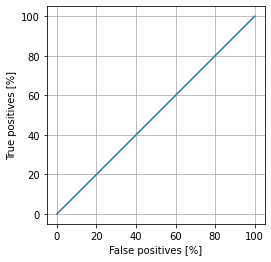

In [18]:
PyPlot.plot(100*falsePositives, 100*truePositives)
PyPlot.xlabel('False positives [%]')
PyPlot.ylabel('True positives [%]')
PyPlot.grid(True)
ax = PyPlot.gca()
ax.set_aspect('equal')
PyPlot.show()

The model is *effectively random* right now, but we are focusing to at least have *a* model to work with.

(the following are temp codes and should be skipped)
```python
# Split the dataset into three 1D ones
leftImageDataset = dataset.map(lambda x, y, z: x, num_parallel_calls=TensorFlow.data.AUTOTUNE)
rightImageDataset = dataset.map(lambda x, y, z: y, num_parallel_calls=TensorFlow.data.AUTOTUNE)
actualLabels = dataset.map(lambda x, y, z: z, num_parallel_calls=TensorFlow.data.AUTOTUNE)

# Create the model's outputs from the first two datasets
leftEmbeddings = smlb.predict(leftImageDataset)
rightEmbeddings = smlb.predict(rightImageDataset)

# Use triplet loss to fill in predictedLabels
semiHardLoss = TensorFlowAddons.losses.TripletSemiHardLoss()
for leftEmbedding, rightEmbedding in zip(leftEmbeddings, rightEmbeddings):
    predictedLabelList.append(semiHardLoss(leftEmbedding, rightEmbedding))

for actualLabel in actualLabels:
    actualLabelList.append(actualLabel)
```
```python
semiHardLoss = TensorFlowAddons.losses.TripletSemiHardLoss()
kerasModel = smlb.get_compiled_model()
for image1, image2, actualLabel in dataset:
    embedding1 = kerasModel(image1)
    embedding2 = kerasModel(image2)
    actualLabelList.append(actualLabel)
    predictedLabelList.append(semiHardLoss(embedding1, embedding2))
```

# 4. Auxillary Functions
Sorry, let me rephrase, I will add some auxiliary functions:
- to check if a given image is in the database, and returns the closest image filename or ""
- to add an image to the database

the GUI can then call these functions and get their results.
## 4.1 Image Checking

In [19]:
import io
import os

_image_database = {}

def _get_embedding_distance(embedding1, embedding2) -> float:
    embeddingDifference = embedding1 - embedding2
    return math.tanh(NumPy.square(embeddingDifference).sum())

def _load_image_database(smlb:SimpleMLBuilder) -> dict:
    database = {}
    for currentDirectory, directoryNames, fileNames in os.walk(DATABASE_DIR):
        for fileName in fileNames:
    return {}

def _get_image_database(smlb:SimpleMLBuilder) -> dict:
    if _image_database.empty():
        _load_image_database(smlb)
    
    return _image_database

def add_image_to_database(imageJpegFilePath:str):
    # TODO
    pass

def get_closest_image(imageJpegFilePath:str, thresholdDistance:float) -> str:
    smlb = SimpleMLBuilder()
    smlb.load("Model 1")
    
    # Load the image file
    imageBinary = TensorFlow.io.read_file(imageJpegFilePath)
    # Decode the image file
    imageRaw = TensorFlow.io.decode_jpeg(imageBinary, channels=3)
    # Resize the raw image
    imageRawResized = TensorFlow.image.resize(
        imageRaw, IMAGE_SIZE, method=TensorFlow.image.ResizeMethod.BICUBIC
    )
    
    kerasModel = smlb.get_compiled_model()
    compEmbedding = kerasModel(imageRawResized)
    bestName = ""
    bestDistance = 1
    for name, embedding in _get_image_database(smlb):
        embeddingDistance = get_embedding_distance(embedding, compEmbedding)
        if embeddingDistance < bestDistance:
            bestName = name
            bestDistance = embeddingDistance
    
    if bestDistance < thresholdDistance:
        return bestName
    else:
        return ""

IndentationError: expected an indented block (<ipython-input-19-b5234d787a97>, line 14)

# 5. Model Improving
The model is in desperate need of improvement.
## 5.1 Testing Automation
The following code was made to automate the process of testing. It is a combination and slight modification of the codes for sections 2.3 and 2.4.

In [4]:
import io
import math
import os
import sklearn.metrics
stringList = []
with open(TESTING_PAIRS_TXT) as fileHandle:
    for line in fileHandle:
        stringList.append(line.split())

# Convert to Tensor
stringTensor = TensorFlow.constant(stringList, TensorFlow.dtypes.string)

stringZeroTensor = TensorFlow.constant('0', TensorFlow.dtypes.string)
floatZeroTensor = TensorFlow.constant(0, TensorFlow.dtypes.float32)
floatOneTensor = TensorFlow.constant(1, TensorFlow.dtypes.float32)

def getImageTensorByAbsolutePath(absolutePath:TensorFlow.Tensor)\
-> TensorFlow.Tensor:
    # Load the image via TensorFlow.io.read_file
    imageBinary = TensorFlow.io.read_file(absolutePath)
    # Decode the binary via TensorFlow.io.decode_jpeg
    imageRaw = TensorFlow.io.decode_jpeg(imageBinary, channels=3)
    # Resize the raw image in case that the image is not 64x64 for some reason
    imageRawResized = TensorFlow.image.resize(
        imageRaw, IMAGE_SIZE, method=TensorFlow.image.ResizeMethod.BICUBIC
    )
    return imageRawResized

def datasetMapper(stringTensor:TensorFlow.Tensor) -> tuple:
    # Start with the first image
    # First, get the relative path
    relativePath = stringTensor[0]
    # We need to have an absolute path, not a relative one, so convert it
    absolutePath = TensorFlow.strings.join([TESTING_PAIRS_DIR, os.path.sep, relativePath])
    # Then, load the image
    image1 = getImageTensorByAbsolutePath(absolutePath)
    
    # Now do it again for image 2
    relativePath = stringTensor[1]
    absolutePath = TensorFlow.strings.join([TESTING_PAIRS_DIR, os.path.sep, relativePath])
    image2 = getImageTensorByAbsolutePath(absolutePath)
    
    # Lastly, the label should be a float, this can be done by checking if
    # the tensor value is zero or not
    parity = TensorFlow.cond(
        stringTensor[2] == stringZeroTensor,
        lambda: floatZeroTensor,
        lambda: floatOneTensor
    )
    
    # Images and label are now good, return them
    return image1, image2, parity

# Turn stringTensor into a dataset first
stringDataset = TensorFlow.data.Dataset.from_tensor_slices(stringTensor)
# Now map the new dataset
dataset = stringDataset.map(
    datasetMapper, num_parallel_calls=TensorFlow.data.AUTOTUNE
)

# Split the dataset into three single value ones
leftImageDataset = dataset.map(lambda x, y, z: x, num_parallel_calls=TensorFlow.data.AUTOTUNE)
rightImageDataset = dataset.map(lambda x, y, z: y, num_parallel_calls=TensorFlow.data.AUTOTUNE)
actualLabels = dataset.map(lambda x, y, z: z, num_parallel_calls=TensorFlow.data.AUTOTUNE)

# Batch the first two datasets
leftImageDataset = leftImageDataset.batch(BATCH_SIZE)
rightImageDataset = rightImageDataset.batch(BATCH_SIZE)

# Create the list of actual values
actualLabelList = []
for actualLabel in actualLabels:
    actualLabelList.append(actualLabel)

def test_model(smlb:SimpleMLBuilder):
    # Get the model and its outputs
    kerasModel = smlb.get_compiled_model()
    leftEmbeddings = kerasModel.predict(leftImageDataset)
    rightEmbeddings = kerasModel.predict(rightImageDataset)
    
    # Calculate the differences
    predictedLabelList = []
    embeddingDifferences = leftEmbeddings - rightEmbeddings
    for embeddingDifference in embeddingDifferences:
        distance = NumPy.square(embeddingDifference).sum()
        predictedLabelList.append(math.tanh(distance))
    
    falsePositives, truePositives, others = sklearn.metrics.roc_curve(actualLabelList, predictedLabelList)
    PyPlot.plot(100*falsePositives, 100*truePositives)
    PyPlot.xlabel('False positives [%]')
    PyPlot.ylabel('True positives [%]')
    PyPlot.grid(True)
    ax = PyPlot.gca()
    ax.set_aspect('equal')
    PyPlot.show()

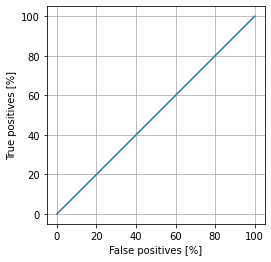

In [21]:
test_model(smlb)

## 4.2 Recreating the Other Datasets
It appears that the datasets have a chance to stop working properly here. They have to be recreated.

In [5]:
import random
seed = random.randrange(0, 16777216)
trainingDataset = Keras.utils.image_dataset_from_directory(
    TRAINING_DIR, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, seed=seed,
    validation_split=VALIDATION_SPLIT, subset="training", interpolation="bicubic"
)
validationDataset = Keras.utils.image_dataset_from_directory(
    TRAINING_DIR, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, seed=seed,
    validation_split=VALIDATION_SPLIT, subset="validation", interpolation="bicubic"
)
trainingOptimizedDataset = trainingDataset.cache().shuffle(1000).prefetch(buffer_size=TensorFlow.data.AUTOTUNE)
validationOptimizedDataset = validationDataset.cache().prefetch(buffer_size=TensorFlow.data.AUTOTUNE)

Found 5000 files belonging to 200 classes.
Using 4500 files for training.
Found 5000 files belonging to 200 classes.
Using 500 files for validation.


## 4.3 Improving the Model
An improved model architecture is the following:

In [15]:
smlb = SimpleMLBuilder(True)
smlb.set_training_features(trainingOptimizedDataset)
smlb.set_validation_dataset(validationOptimizedDataset)

smlb.start_layering((64, 64, 3))
smlb.add_rescaling_layer()
smlb.add_convolution_layer(64, (3,3), pad=True)
smlb.add_activation_layer("relu")
smlb.add_dropout_layer(0.2)
smlb.add_convolution_layer(64, (3,3), pad=True)
smlb.add_activation_layer("relu")
smlb.add_dropout_layer(0.2)
smlb.add_convolution_layer(64, (3,3), pad=True)
smlb.add_activation_layer("relu")
smlb.add_pooling_layer("max", (2,2), (2,2))
smlb.add_convolution_layer(128, (3,3), pad=True)
smlb.add_activation_layer("relu")
smlb.add_dropout_layer(0.2)
smlb.add_convolution_layer(128, (3,3), pad=True)
smlb.add_activation_layer("relu")
smlb.add_dropout_layer(0.2)
smlb.add_convolution_layer(128, (3,3), pad=True)
smlb.add_activation_layer("relu")
smlb.add_pooling_layer("max", (2,2), (2,2))
smlb.add_convolution_layer(256, (3,3), pad=True)
smlb.add_activation_layer("relu")
smlb.add_convolution_layer(256, (3,3), pad=True)
smlb.add_activation_layer("relu")
smlb.add_convolution_layer(256, (3,3), pad=True)
smlb.add_activation_layer("relu")
smlb.add_flatten_layer()
smlb.add_dense_layer(256)
smlb.add_regularization_sublayer("l2")

smlb.set_custom_loss_function(TensorFlowAddons.losses.TripletSemiHardLoss())
smlb.build(0.0001)

[SMLB] Fully initialized!
[SMLB] Training X values have been set!
[SMLB] Validation dataset has been set!
[SMLB] Layering started. Added layer: {'type': 'Input', 'shape': (64, 64, 3)}
[SMLB] Added layer: {'type': 'Rescaling', 'scale': 0.00392156862745098, 'offset': 0.0}
[SMLB] Added layer: {'type': 'Conv2D', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same'}
[SMLB] Modified layer: {'type': 'Conv2D', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'activation': 'relu'}
[SMLB] Added layer: {'type': 'Dropout', 'rate': 0.2}
[SMLB] Added layer: {'type': 'Conv2D', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same'}
[SMLB] Modified layer: {'type': 'Conv2D', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'activation': 'relu'}
[SMLB] Added layer: {'type': 'Dropout', 'rate': 0.2}
[SMLB] Added layer: {'type': 'Conv2D', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same'

In [16]:
smlb.run(100, earlyStop=True)

Epoch 1/100
45/45 [==============================] - 13s 273ms/step - loss: 0.9410 - val_loss: 0.8657
Epoch 2/100
45/45 [==============================] - 12s 273ms/step - loss: 0.3996 - val_loss: 0.7049
Epoch 3/100
45/45 [==============================] - 12s 275ms/step - loss: 0.2744 - val_loss: 0.6295
Epoch 4/100
45/45 [==============================] - 12s 273ms/step - loss: 0.2318 - val_loss: 0.4857
Epoch 5/100
45/45 [==============================] - 12s 272ms/step - loss: 0.2828 - val_loss: 0.5774
Epoch 6/100
45/45 [==============================] - 12s 271ms/step - loss: 0.1966 - val_loss: 0.5951
Epoch 7/100
45/45 [==============================] - 12s 263ms/step - loss: 0.1249 - val_loss: 0.2163
Epoch 8/100
45/45 [==============================] - 12s 269ms/step - loss: 0.1573 - val_loss: 0.2322
Epoch 9/100
45/45 [==============================] - 13s 285ms/step - loss: 0.1315 - val_loss: 0.1982
Epoch 10/100
45/45 [==============================] - 12s 262ms/step - loss: 0.116

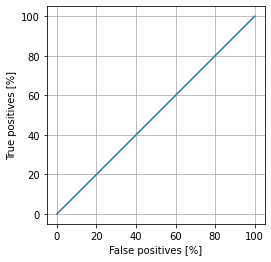

In [17]:
test_model(smlb)